In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-09 03:26:12--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.28.6, 16.182.37.120, 52.216.221.128, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.28.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.3’

jena_climate_2009_2 100%[===================>]  12.94M  57.7MB/s    in 0.2s    

2024-04-09 03:26:12 (57.7 MB/s) - ‘jena_climate_2009_2016.csv.zip.3’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [27]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [28]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

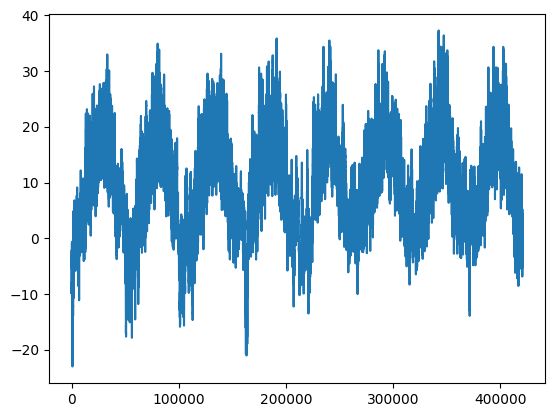

In [29]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

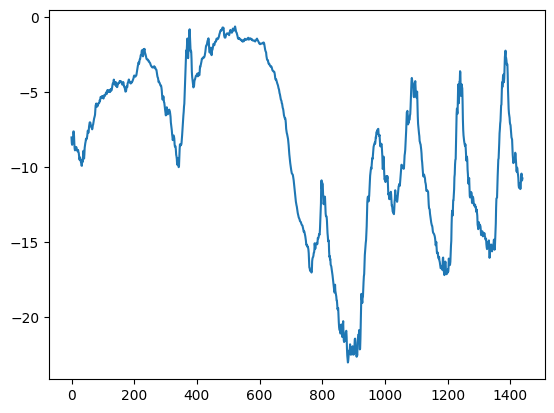

In [30]:
plt.plot(range(1440), temperature[:1440])

In [31]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [32]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


****Model 0: common-sense, non-machine-learning baseline****

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


***Model1: Basic machine learning model***

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 52s 62ms/step - loss: 12.4057 - mae: 2.7220 - val_loss: 10.3898 - val_mae: 2.5445
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 8.9018 - mae: 2.3435 - val_loss: 10.5992 - val_mae: 2.5699
Epoch 3/10
819/819 [==============================] - 52s 63ms/step - loss: 8.1799 - mae: 2.2484 - val_loss: 10.5651 - val_mae: 2.5614
Epoch 4/10
819/819 [==============================] - 50s 61ms/step - loss: 7.7496 - mae: 2.1912 - val_loss: 10.6162 - val_mae: 2.5708
Epoch 5/10
819/819 [==============================] - 43s 52ms/step - loss: 7.5011 - mae: 2.1567 - val_loss: 11.5391 - val_mae: 2.6944
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 7.2644 - mae: 2.1226 - val_loss: 11.1705 - val_mae: 2.6488
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 7.0842 - mae: 2.0981 - val_loss: 11.6870 - val_mae: 2.7130
Epoch 8/10
819/819 [==============================] - 

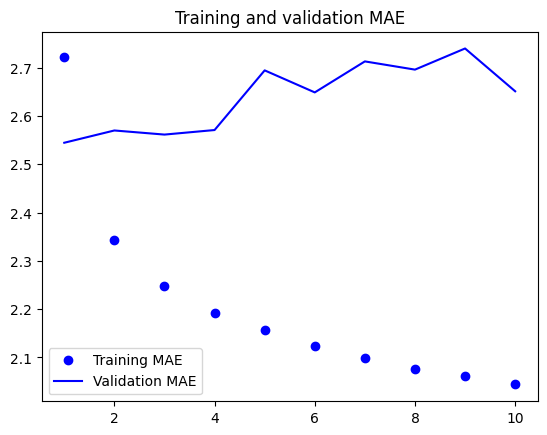

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

***Model 2: 1D CONV***

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 75s 90ms/step - loss: 21.5014 - mae: 3.6370 - val_loss: 16.6413 - val_mae: 3.1986
Epoch 2/10
819/819 [==============================] - 78s 95ms/step - loss: 15.6853 - mae: 3.1510 - val_loss: 18.6506 - val_mae: 3.4233
Epoch 3/10
819/819 [==============================] - 85s 104ms/step - loss: 14.4235 - mae: 3.0128 - val_loss: 15.0804 - val_mae: 3.0731
Epoch 4/10
819/819 [==============================] - 76s 93ms/step - loss: 13.4472 - mae: 2.9032 - val_loss: 14.1008 - val_mae: 2.9569
Epoch 5/10
819/819 [==============================] - 78s 95ms/step - loss: 12.7034 - mae: 2.8208 - val_loss: 14.7409 - val_mae: 3.0309
Epoch 6/10
819/819 [==============================] - 77s 94ms/step - loss: 12.1579 - mae: 2.7595 - val_loss: 13.7677 - val_mae: 2.9199
Epoch 7/10
819/819 [==============================] - 77s 93ms/step - loss: 11.7576 - mae: 2.7137 - val_loss: 14.3307 - val_mae: 2.9772
Epoch 8/10
819/819 [===========================

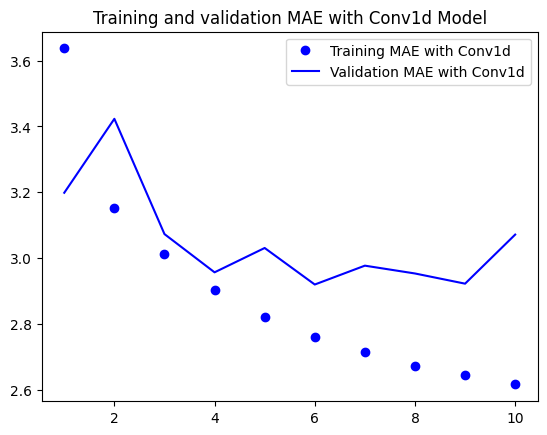

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE with Conv1d")
plt.plot(epochs, val_loss, "b", label="Validation MAE with Conv1d")
plt.title("Training and validation MAE with Conv1d Model")
plt.legend()
plt.show()

*Model 3.0: Simple RNN Layers*

In [16]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 73s 87ms/step - loss: 139.4217 - mae: 9.7233 - val_loss: 143.9630 - val_mae: 9.8982
Epoch 2/5
819/819 [==============================] - 75s 91ms/step - loss: 136.3528 - mae: 9.5568 - val_loss: 143.6783 - val_mae: 9.8644
Epoch 3/5
819/819 [==============================] - 68s 83ms/step - loss: 136.2642 - mae: 9.5468 - val_loss: 143.6692 - val_mae: 9.8642
Epoch 4/5
819/819 [==============================] - 69s 83ms/step - loss: 136.2082 - mae: 9.5404 - val_loss: 143.5779 - val_mae: 9.8517
Epoch 5/5
405/405 [==============================] - 19s 45ms/step - loss: 151.3478 - mae: 9.9256
Test MAE: 9.93


**Model 3.1:Stacking RNN layers***

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_RNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 141s 169ms/step - loss: 137.0429 - mae: 9.5776 - val_loss: 143.4084 - val_mae: 9.8356
Epoch 2/10
819/819 [==============================] - 119s 145ms/step - loss: 135.9572 - mae: 9.5139 - val_loss: 143.3828 - val_mae: 9.8329
Epoch 3/10
819/819 [==============================] - 137s 167ms/step - loss: 135.9152 - mae: 9.5080 - val_loss: 143.3759 - val_mae: 9.8308
Epoch 4/10
819/819 [==============================] - 138s 168ms/step - loss: 135.8749 - mae: 9.5026 - val_loss: 143.4106 - val_mae: 9.8352
Epoch 5/10
819/819 [==============================] - 138s 168ms/step - loss: 135.8611 - mae: 9.4996 - val_loss: 143.3838 - val_mae: 9.8318
Epoch 6/10
819/819 [==============================] - 137s 167ms/step - loss: 135.8468 - mae: 9.4982 - val_loss: 143.3663 - val_mae: 9.8289
Epoch 7/10
819/819 [==============================] - 120s 146ms/step - loss: 135.8436 - mae: 9.4976 - val_loss: 143.3755 - val_mae: 9.8325
Epoch 8/10
819/819 [

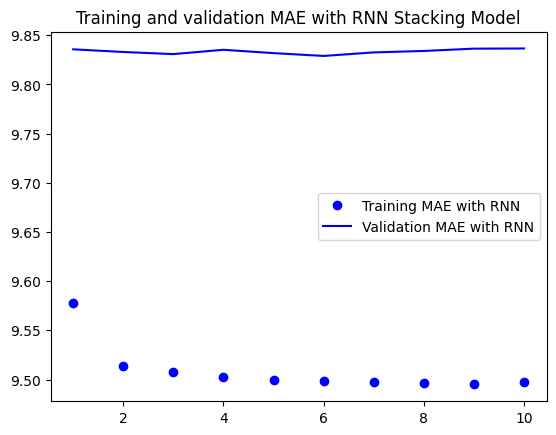

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE with RNN")
plt.plot(epochs, val_loss, "b", label="Validation MAE with RNN")
plt.title("Training and validation MAE with RNN Stacking Model")
plt.legend()
plt.show()

***Model 4:RNN with 32 units***

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)
outputs = layers.SimpleRNN(32)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_RNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 163s 197ms/step - loss: 136.4157 - mae: 9.5476 - val_loss: 143.3915 - val_mae: 9.8335
Epoch 2/10
819/819 [==============================] - 160s 195ms/step - loss: 135.9242 - mae: 9.5085 - val_loss: 143.4262 - val_mae: 9.8372
Epoch 3/10
819/819 [==============================] - 160s 196ms/step - loss: 135.8709 - mae: 9.5008 - val_loss: 143.3513 - val_mae: 9.8294
Epoch 4/10
819/819 [==============================] - 161s 196ms/step - loss: 135.8375 - mae: 9.4960 - val_loss: 143.3583 - val_mae: 9.8288
Epoch 5/10
819/819 [==============================] - 146s 178ms/step - loss: 135.8139 - mae: 9.4925 - val_loss: 143.3732 - val_mae: 9.8285
Epoch 6/10
819/819 [==============================] - 160s 195ms/step - loss: 135.7999 - mae: 9.4902 - val_loss: 143.6187 - val_mae: 9.8665
Epoch 7/10
819/819 [==============================] - 162s 198ms/step - loss: 135.7853 - mae: 9.4878 - val_loss: 143.3774 - val_mae: 9.8317
Epoch 8/10
819/819 [

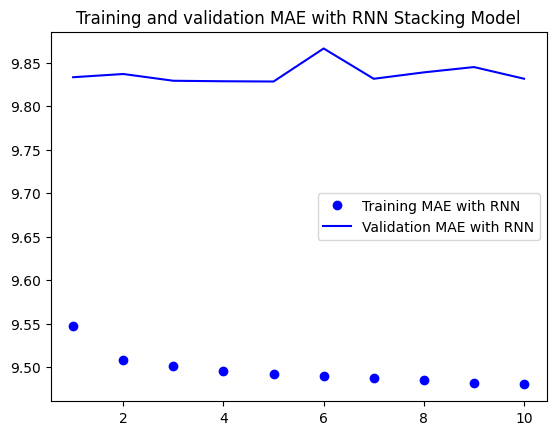

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE with RNN")
plt.plot(epochs, val_loss, "b", label="Validation MAE with RNN")
plt.title("Training and validation MAE with RNN Stacking Model")
plt.legend()
plt.show()

***Model 5:RNN with 48 units***

In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(48, return_sequences=True)(inputs)
x = layers.SimpleRNN(48, return_sequences=True)(x)
outputs = layers.SimpleRNN(48)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_RNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_RNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 194s 232ms/step - loss: 136.3278 - mae: 9.5388 - val_loss: 143.4586 - val_mae: 9.8448
Epoch 2/10
819/819 [==============================] - 184s 225ms/step - loss: 135.8830 - mae: 9.5041 - val_loss: 143.4810 - val_mae: 9.8480
Epoch 3/10
819/819 [==============================] - 192s 234ms/step - loss: 135.8246 - mae: 9.4947 - val_loss: 143.4376 - val_mae: 9.8406
Epoch 4/10
819/819 [==============================] - 191s 233ms/step - loss: 135.7804 - mae: 9.4873 - val_loss: 143.4144 - val_mae: 9.8358
Epoch 5/10
819/819 [==============================] - 192s 234ms/step - loss: 135.7438 - mae: 9.4803 - val_loss: 143.4524 - val_mae: 9.8477
Epoch 6/10
819/819 [==============================] - 187s 229ms/step - loss: 135.7383 - mae: 9.4790 - val_loss: 143.4968 - val_mae: 9.8507
Epoch 7/10
819/819 [==============================] - 184s 225ms/step - loss: 135.7172 - mae: 9.4749 - val_loss: 143.4420 - val_mae: 9.8433
Epoch 8/10
819/819 [

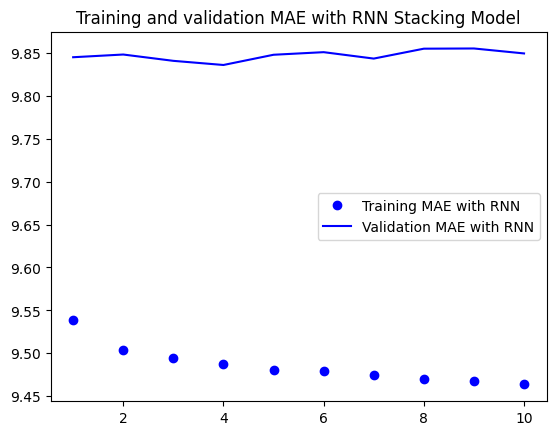

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE with RNN")
plt.plot(epochs, val_loss, "b", label="Validation MAE with RNN")
plt.title("Training and validation MAE with RNN Stacking Model")
plt.legend()
plt.show()

***Model 6:LSTM dropout***

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 121s 146ms/step - loss: 106.4647 - mae: 8.3512 - val_loss: 73.0477 - val_mae: 6.9270
Epoch 2/10
819/819 [==============================] - 124s 151ms/step - loss: 74.4707 - mae: 6.8859 - val_loss: 56.2870 - val_mae: 6.0678
Epoch 3/10
819/819 [==============================] - 127s 154ms/step - loss: 68.9448 - mae: 6.5843 - val_loss: 51.3137 - val_mae: 5.7439
Epoch 4/10
819/819 [==============================] - 121s 148ms/step - loss: 66.1402 - mae: 6.4172 - val_loss: 48.9466 - val_mae: 5.6008
Epoch 5/10
819/819 [==============================] - 121s 147ms/step - loss: 64.8986 - mae: 6.3488 - val_loss: 46.6420 - val_mae: 5.4451
Epoch 6/10
819/819 [==============================] - 121s 147ms/step - loss: 63.8486 - mae: 6.2931 - val_loss: 44.9362 - val_mae: 5.3395
Epoch 7/10
819/819 [==============================] - 121s 147ms/step - loss: 63.3580 - mae: 6.2741 - val_loss: 43.9994 - val_mae: 5.2697
Epoch 8/10
819/819 [=============

In [ ]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 20s 47ms/step - loss: 44.3158 - mae: 5.2020
Test MAE: 5.20


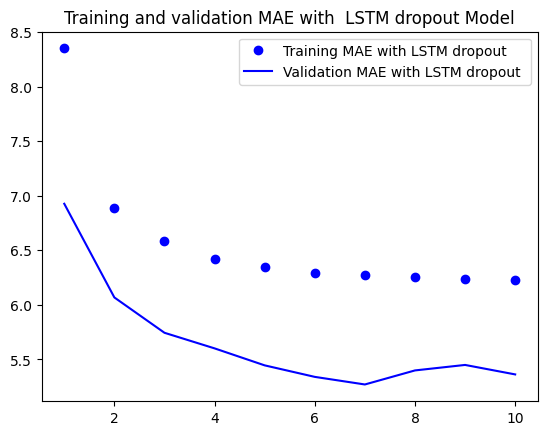

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE with LSTM dropout ")
plt.plot(epochs, val_loss, "b", label="Validation MAE with LSTM dropout ")
plt.title("Training and validation MAE with  LSTM dropout Model")
plt.legend()
plt.show()

***Model 7:LSTM DROPOUT with 0.35***

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.35)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 132s 159ms/step - loss: 99.4599 - mae: 7.9435 - val_loss: 63.1064 - val_mae: 6.1445
Epoch 2/10
819/819 [==============================] - 159s 194ms/step - loss: 55.0784 - mae: 5.7259 - val_loss: 31.5440 - val_mae: 4.3318
Epoch 3/10
819/819 [==============================] - 131s 160ms/step - loss: 42.2761 - mae: 5.0089 - val_loss: 22.4343 - val_mae: 3.6027
Epoch 4/10
819/819 [==============================] - 136s 166ms/step - loss: 37.3045 - mae: 4.7047 - val_loss: 19.9047 - val_mae: 3.4367
Epoch 5/10
819/819 [==============================] - 137s 167ms/step - loss: 35.2769 - mae: 4.5725 - val_loss: 20.8828 - val_mae: 3.5922
Epoch 6/10
819/819 [==============================] - 131s 159ms/step - loss: 33.8283 - mae: 4.4752 - val_loss: 16.2110 - val_mae: 3.0661
Epoch 7/10
819/819 [==============================] - 129s 157ms/step - loss: 32.8174 - mae: 4.4032 - val_loss: 15.8029 - val_mae: 3.0686
Epoch 8/10
819/819 [==============

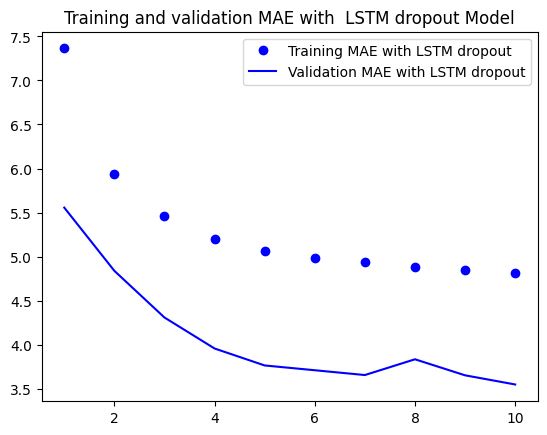

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE with LSTM dropout ")
plt.plot(epochs, val_loss, "b", label="Validation MAE with LSTM dropout")
plt.title("Training and validation MAE with  LSTM dropout Model")
plt.legend()
plt.show()

***Model 8:LSTM DROPOUT with 0.45***

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.45)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 137s 165ms/step - loss: 95.6981 - mae: 7.8176 - val_loss: 48.4625 - val_mae: 5.5212
Epoch 2/10
819/819 [==============================] - 132s 161ms/step - loss: 56.7060 - mae: 5.9078 - val_loss: 39.8520 - val_mae: 4.9589
Epoch 3/10
819/819 [==============================] - 128s 156ms/step - loss: 50.4363 - mae: 5.5566 - val_loss: 30.1681 - val_mae: 4.2770
Epoch 4/10
819/819 [==============================] - 129s 157ms/step - loss: 48.1354 - mae: 5.4163 - val_loss: 27.9185 - val_mae: 4.0749
Epoch 5/10
819/819 [==============================] - 129s 157ms/step - loss: 47.0692 - mae: 5.3432 - val_loss: 25.2971 - val_mae: 3.8567
Epoch 6/10
819/819 [==============================] - 131s 160ms/step - loss: 46.4861 - mae: 5.3085 - val_loss: 25.0692 - val_mae: 3.8486
Epoch 7/10
819/819 [==============================] - 128s 156ms/step - loss: 45.6778 - mae: 5.2604 - val_loss: 26.8862 - val_mae: 4.0232
Epoch 8/10
819/819 [==============

In [ ]:
model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 19s 46ms/step - loss: 25.6877 - mae: 3.8510
Test MAE: 3.85


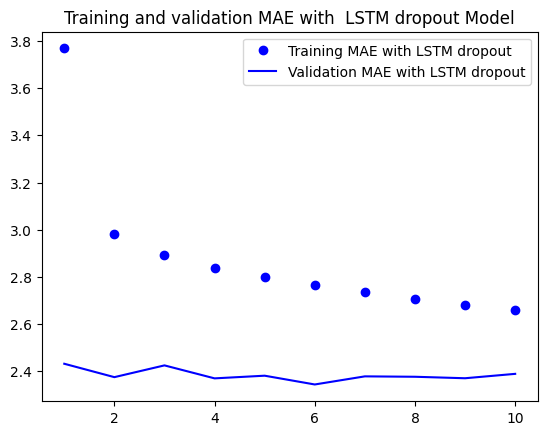

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE with LSTM dropout ")
plt.plot(epochs, val_loss, "b", label="Validation MAE with LSTM dropout")
plt.title("Training and validation MAE with  LSTM dropout Model")
plt.legend()
plt.show()

*Model 9.0: Simple GRU*

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 227s 274ms/step - loss: 87.7342 - mae: 7.5643 - val_loss: 66.9090 - val_mae: 6.7298
Epoch 2/5
819/819 [==============================] - 217s 265ms/step - loss: 80.0239 - mae: 7.2392 - val_loss: 66.7602 - val_mae: 6.7232
Epoch 3/5
819/819 [==============================] - 216s 263ms/step - loss: 79.5233 - mae: 7.2178 - val_loss: 66.8485 - val_mae: 6.7274
Epoch 4/5
819/819 [==============================] - 234s 286ms/step - loss: 79.1060 - mae: 7.2000 - val_loss: 66.7157 - val_mae: 6.7211
Epoch 5/5
405/405 [==============================] - 36s 86ms/step - loss: 67.6212 - mae: 6.6858
Test MAE: 6.69


***Model 10:GRU with stacking layers with 32 units***

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 331s 398ms/step - loss: 24.4381 - mae: 3.6529 - val_loss: 9.6352 - val_mae: 2.4026
Epoch 2/10
819/819 [==============================] - 324s 395ms/step - loss: 13.9965 - mae: 2.8981 - val_loss: 8.9788 - val_mae: 2.3262
Epoch 3/10
819/819 [==============================] - 325s 396ms/step - loss: 13.2783 - mae: 2.8216 - val_loss: 8.9293 - val_mae: 2.3216
Epoch 4/10
819/819 [==============================] - 322s 392ms/step - loss: 12.5906 - mae: 2.7480 - val_loss: 9.0021 - val_mae: 2.3444
Epoch 5/10
819/819 [==============================] - 327s 399ms/step - loss: 12.1068 - mae: 2.6969 - val_loss: 8.7578 - val_mae: 2.3060
Epoch 6/10
819/819 [==============================] - 326s 397ms/step - loss: 11.6812 - mae: 2.6510 - val_loss: 8.9930 - val_mae: 2.3340
Epoch 7/10
819/819 [==============================] - 327s 398ms/step - loss: 11.4067 - mae: 2.6175 - val_loss: 9.1328 - val_mae: 2.3441
Epoch 8/10
819/819 [=====================

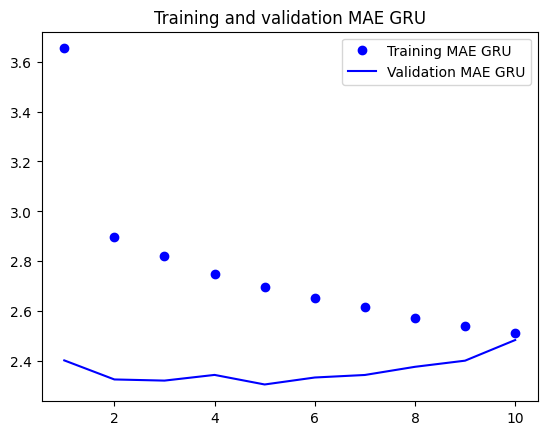

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE GRU")
plt.plot(epochs, val_loss, "b", label="Validation MAE GRU")
plt.title("Training and validation MAE GRU")
plt.legend()
plt.show()

***Model 11:GRU stacking with 16 units***

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(16, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 256s 307ms/step - loss: 37.1256 - mae: 4.4988 - val_loss: 12.0218 - val_mae: 2.6228
Epoch 2/10
819/819 [==============================] - 239s 292ms/step - loss: 18.3454 - mae: 3.2817 - val_loss: 9.6824 - val_mae: 2.4040
Epoch 3/10
819/819 [==============================] - 238s 291ms/step - loss: 17.0330 - mae: 3.1701 - val_loss: 9.0284 - val_mae: 2.3293
Epoch 4/10
819/819 [==============================] - 239s 292ms/step - loss: 16.3096 - mae: 3.0999 - val_loss: 9.5519 - val_mae: 2.4082
Epoch 5/10
819/819 [==============================] - 243s 296ms/step - loss: 15.7117 - mae: 3.0476 - val_loss: 9.1314 - val_mae: 2.3463
Epoch 6/10
819/819 [==============================] - 240s 293ms/step - loss: 15.0883 - mae: 2.9891 - val_loss: 8.9698 - val_mae: 2.3296
Epoch 7/10
819/819 [==============================] - 242s 296ms/step - loss: 14.5674 - mae: 2.9398 - val_loss: 9.8082 - val_mae: 2.4368
Epoch 8/10
819/819 [====================

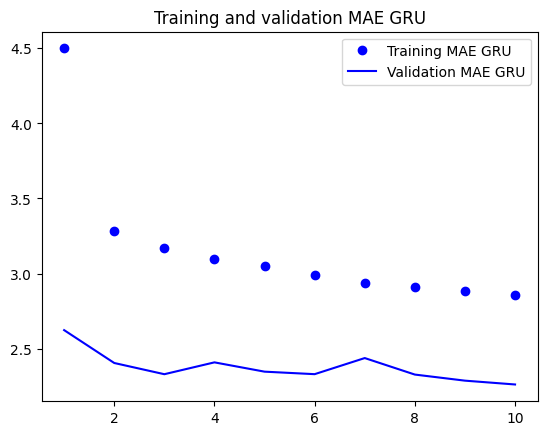

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE GRU")
plt.plot(epochs, val_loss, "b", label="Validation MAE GRU")
plt.title("Training and validation MAE GRU")
plt.legend()
plt.show()

***Model 12:GRU stacking with 48 units****

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(48, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(48, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 461s 557ms/step - loss: 19.5516 - mae: 3.3008 - val_loss: 8.9520 - val_mae: 2.3210
Epoch 2/10
819/819 [==============================] - 455s 555ms/step - loss: 12.4385 - mae: 2.7456 - val_loss: 9.0990 - val_mae: 2.3454
Epoch 3/10
819/819 [==============================] - 453s 553ms/step - loss: 11.6710 - mae: 2.6619 - val_loss: 8.8835 - val_mae: 2.3234
Epoch 4/10
819/819 [==============================] - 457s 558ms/step - loss: 11.1457 - mae: 2.6025 - val_loss: 9.0403 - val_mae: 2.3217
Epoch 5/10
819/819 [==============================] - 423s 516ms/step - loss: 10.5419 - mae: 2.5320 - val_loss: 8.8884 - val_mae: 2.3137
Epoch 6/10
819/819 [==============================] - 458s 559ms/step - loss: 10.0421 - mae: 2.4677 - val_loss: 9.1148 - val_mae: 2.3343
Epoch 7/10
819/819 [==============================] - 458s 559ms/step - loss: 9.5134 - mae: 2.4009 - val_loss: 9.3242 - val_mae: 2.3595
Epoch 8/10
819/819 [======================

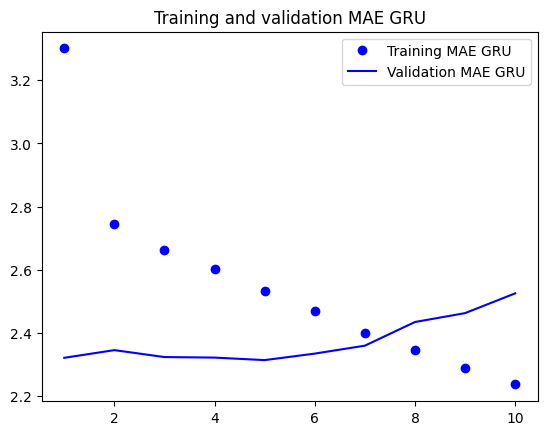

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE GRU")
plt.plot(epochs, val_loss, "b", label="Validation MAE GRU")
plt.title("Training and validation MAE GRU")
plt.legend()
plt.show()

***Model 13:Bidirectional LSTM***

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bi-direc_LSTM.keras", save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=7,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model=keras.models.load_model("jena_bi-direc_LSTM.keras",safe_mode=False)
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/7
819/819 [==============================] - 115s 137ms/step - loss: 103.6516 - mae: 8.2103 - val_loss: 64.4420 - val_mae: 6.4204
Epoch 2/7
819/819 [==============================] - 101s 123ms/step - loss: 55.0374 - mae: 5.8432 - val_loss: 41.6542 - val_mae: 5.1371
Epoch 3/7
819/819 [==============================] - 97s 118ms/step - loss: 44.3251 - mae: 5.1828 - val_loss: 35.1641 - val_mae: 4.6823
Epoch 4/7
819/819 [==============================] - 99s 121ms/step - loss: 38.1018 - mae: 4.7972 - val_loss: 31.6992 - val_mae: 4.4207
Epoch 5/7
819/819 [==============================] - 96s 117ms/step - loss: 34.0097 - mae: 4.5474 - val_loss: 30.4583 - val_mae: 4.3139
Epoch 6/7
819/819 [==============================] - 99s 120ms/step - loss: 31.7824 - mae: 4.4126 - val_loss: 29.7712 - val_mae: 4.2791
Epoch 7/7
405/405 [==============================] - 22s 51ms/step - loss: 31.2038 - mae: 4.3911
Test MAE: 4.39


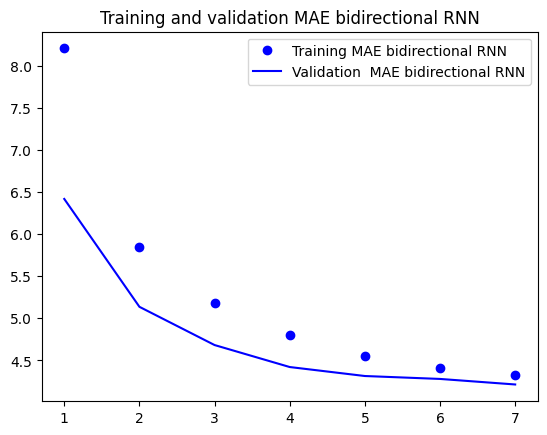

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE bidirectional RNN")
plt.plot(epochs, val_loss, "b", label="Validation  MAE bidirectional RNN")
plt.title("Training and validation MAE bidirectional RNN")
plt.legend()
plt.show()

*** Model 14:LSTM with   16 units***

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(16, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 299s 351ms/step - loss: 49.4579 - mae: 5.2316 - val_loss: 14.7415 - val_mae: 2.8834
Epoch 2/5
819/819 [==============================] - 270s 329ms/step - loss: 19.2288 - mae: 3.3560 - val_loss: 9.8019 - val_mae: 2.4195
Epoch 3/5
819/819 [==============================] - 270s 329ms/step - loss: 17.2379 - mae: 3.1882 - val_loss: 9.7234 - val_mae: 2.4227
Epoch 4/5
405/405 [==============================] - 37s 88ms/step - loss: 10.4957 - mae: 2.5340
Test MAE: 2.53


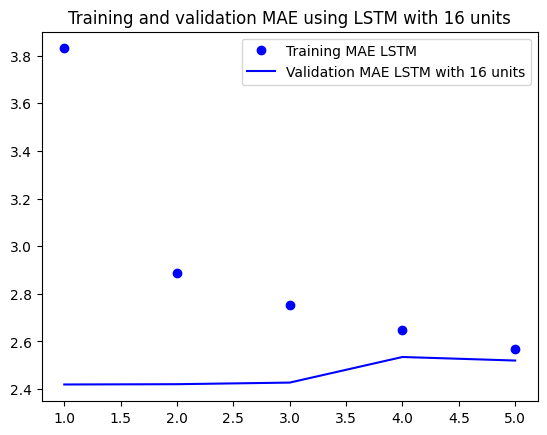

In [19]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE LSTM")
plt.plot(epochs, val_loss, "b", label="Validation MAE LSTM with 16 units")
plt.title("Training and validation MAE using LSTM with 16 units")
plt.legend()
plt.show()

***  Model 15: LSTM with 32 units***

In [18]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 431s 518ms/step - loss: 27.0503 - mae: 3.8301 - val_loss: 9.7048 - val_mae: 2.4194
Epoch 2/5
819/819 [==============================] - 430s 525ms/step - loss: 13.9124 - mae: 2.8873 - val_loss: 9.6167 - val_mae: 2.4206
Epoch 3/5
819/819 [==============================] - 429s 523ms/step - loss: 12.6408 - mae: 2.7541 - val_loss: 9.8021 - val_mae: 2.4273
Epoch 4/5
819/819 [==============================] - 426s 520ms/step - loss: 11.7310 - mae: 2.6472 - val_loss: 10.5376 - val_mae: 2.5348
Epoch 5/5
405/405 [==============================] - 50s 120ms/step - loss: 10.8244 - mae: 2.5623
Test MAE: 2.56


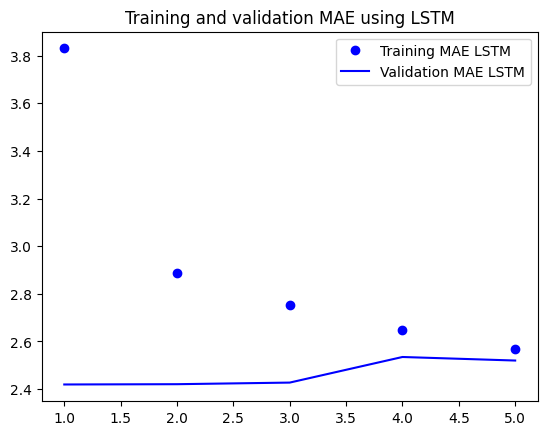

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE LSTM")
plt.plot(epochs, val_loss, "b", label="Validation MAE LSTM")
plt.title("Training and validation MAE using LSTM")
plt.legend()
plt.show()

*** Model 16: LSTM with 48 units***

In [15]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(16, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 292s 349ms/step - loss: 46.8167 - mae: 5.0807 - val_loss: 13.3545 - val_mae: 2.7380
Epoch 2/5
819/819 [==============================] - 283s 345ms/step - loss: 19.0900 - mae: 3.3460 - val_loss: 10.0144 - val_mae: 2.4419
Epoch 3/5
819/819 [==============================] - 282s 344ms/step - loss: 17.1961 - mae: 3.1784 - val_loss: 9.2987 - val_mae: 2.3536
Epoch 4/5
819/819 [==============================] - 281s 343ms/step - loss: 16.2493 - mae: 3.0933 - val_loss: 9.1822 - val_mae: 2.3370
Epoch 5/5
405/405 [==============================] - 43s 104ms/step - loss: 10.4181 - mae: 2.5189
Test MAE: 2.52


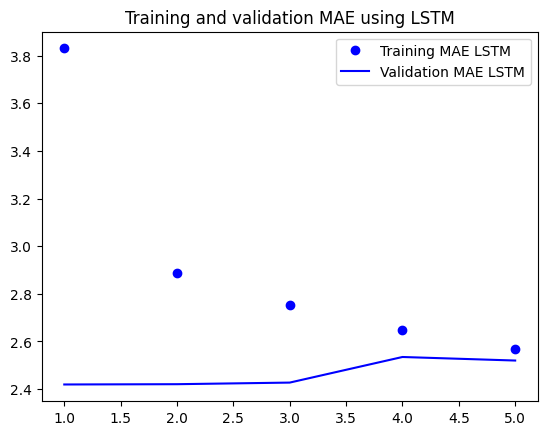

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE LSTM")
plt.plot(epochs, val_loss, "b", label="Validation MAE LSTM")
plt.title("Training and validation MAE using LSTM")
plt.legend()
plt.show()

***Model 17:Using layer_LSTM() instead of layer_GRU()***

In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/3
819/819 [==============================] - 284s 340ms/step - loss: 81.8265 - mae: 7.3131 - val_loss: 66.5807 - val_mae: 6.7130
Epoch 2/3
819/819 [==============================] - 283s 345ms/step - loss: 78.5030 - mae: 7.1733 - val_loss: 66.5490 - val_mae: 6.7126
Epoch 3/3
405/405 [==============================] - 44s 106ms/step - loss: 67.4845 - mae: 6.6825
Test MAE: 6.68


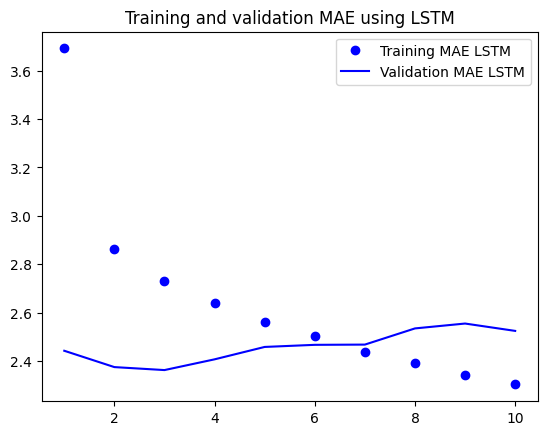

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE LSTM")
plt.plot(epochs, val_loss, "b", label="Validation MAE LSTM")
plt.title("Training and validation MAE using LSTM")
plt.legend()
plt.show()

*****Model 19:1D Convnets combined with RNN togther***

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation="relu")(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Reshape((-1,128))(x)

# LSTM layer
x = layers.LSTM(16, dropout=0.45)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 [==============================] - 74s 88ms/step - loss: 95.3248 - mae: 7.9057 - val_loss: 66.7767 - val_mae: 6.7240
Epoch 2/5
819/819 [==============================] - 68s 83ms/step - loss: 81.9613 - mae: 7.3185 - val_loss: 65.7995 - val_mae: 6.6775
Epoch 3/5
819/819 [==============================] - 73s 89ms/step - loss: 80.2282 - mae: 7.2469 - val_loss: 64.2949 - val_mae: 6.6044
Epoch 4/5
819/819 [==============================] - 66s 80ms/step - loss: 44.5519 - mae: 5.2109 - val_loss: 24.3703 - val_mae: 3.8578
Epoch 5/5
405/405 [==============================] - 16s 36ms/step - loss: 27.4856 - mae: 4.0727
Test MAE: 4.07


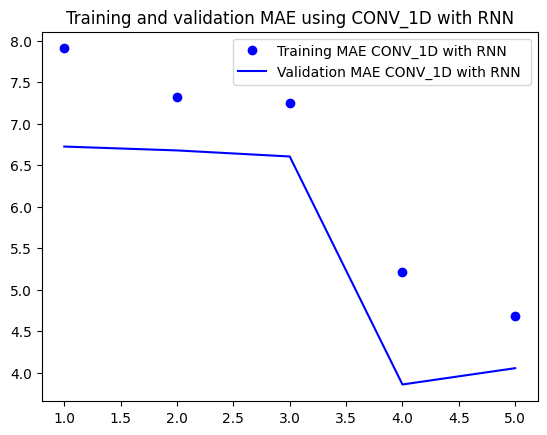

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE CONV_1D with RNN")
plt.plot(epochs, val_loss, "b", label="Validation MAE CONV_1D with RNN ")
plt.title("Training and validation MAE using CONV_1D with RNN")
plt.legend()
plt.show()

***There are 14 models with changeover stacking units***

Model_0- common-sense, non-machine-learning baseline

Model_1- A basic machine-learning model

Model_2- 1D_Convolution model

Model_3- Simple RNN with 16 units

Model_4- Stacked RNN with 16 units

Model_5- Stacked RNN with 32 units

Model_6- Stacked RNN with 48 units

Model_7- LSTM dropout with 0.25

Model_8- LSTM dropout with 0.35

Model_9- LSTM dropout with 0.45

Model-10- Simple GRU

Model_11- GRU Stacking with 16 units

Model_12- GRU Stacking with 32 units

Model_13- GRU Stacking with 48 units

Model_14- Bi-Directional LSTM()

Model_15- LSTM with 16 units

Model_16- LSTM with 32 units

Model-17- LSTM with 48 units

Model-18- Using layer_LSTM() instead of layer_GRU() Simple LSTM

Model-19- 1D Convnets combined with RNN togther

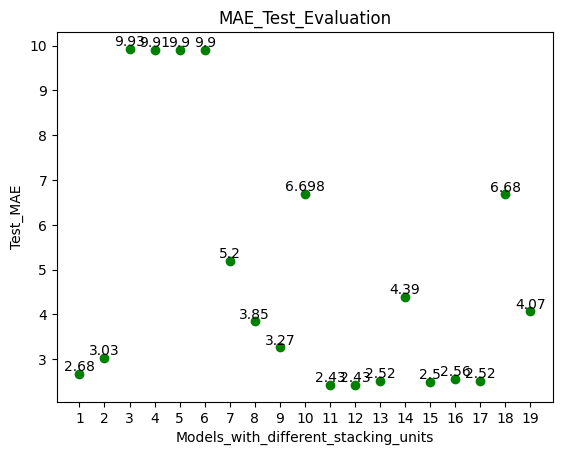

In [3]:
import matplotlib.pyplot as plt
Models = ("1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19")
Mae = (2.68,3.03,9.93,9.91,9.90,9.90,5.20,3.85,3.27,6.698,2.43,2.43,2.52,4.39,2.5,2.56,2.52,6.68,4.07)

# MAE Evaluation
plt.scatter(Models, Mae, color="green")
plt.title("MAE_Test_Evaluation")
plt.xlabel("Models_with_different_stacking_units")
plt.ylabel("Test_MAE")

for (xi, yi) in zip(Models,Mae):
    plt.text(xi, yi, yi, va='bottom', ha='center')